In [1]:
import os, requests, json
from math import floor
import pyproj
import overpy
import pandas as pd
import geemap
import ee
import shapely
from shapely.geometry import Polygon, MultiPolygon
from shapely.geometry import shape as Shape
from shapely.ops import unary_union, transform

#ee.Authenticate()

C:\Users\theodore.wong\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\theodore.wong\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.4SP5SUA7CBGXUEOC35YP2ASOICYYEQZZ.gfortran-win_amd64.dll
C:\Users\theodore.wong\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
C:\Users\theodore.wong\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-246-g3d31191b-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
ee.Initialize()

In [3]:
boundaries_foldername = 'Deep Dive boundaries'
geos = []
for city_geojson_filename in os.listdir(boundaries_foldername):
    info_part = city_geojson_filename.split('.')[0]
    bfile = open('{0}/{1}'.format(boundaries_foldername, city_geojson_filename), encoding="utf-8")
    country_code = info_part.split('-')[1]
    cityname = info_part.split('-')[2]
    level = '-'.join(info_part.split('-')[3:])
    geos.append((country_code, cityname, level, bfile.read()))
    bfile.close()

#Jakarta
boundary_georef = pd.read_csv('https://cities-urbanshift.s3.eu-west-3.amazonaws.com/data/boundaries/v_0/boundary_georef.csv')
i = 25
boundary_id_aoi = '{0}-{1}'.format(boundary_georef.loc[i, 'geo_name'], boundary_georef.loc[i, 'aoi_boundary_name'])
boundary_path = 'https://cities-urbanshift.s3.eu-west-3.amazonaws.com/data/boundaries/v_0/boundary-{0}.geojson'.format(boundary_id_aoi)
boundary_geo = requests.get(boundary_path).json()
geos.append((boundary_georef.loc[i, 'country_code'], boundary_georef.loc[i, 'city_name'], boundary_georef.loc[i, 'units_boundary_name'], json.dumps(boundary_geo)))

In [4]:
boundary_georef

,geo_name,level,aoi_boundary_name,units_boundary_name,city_name,country_name,country_code,continent
0,ARG-Mendoza,region,ADM3union,ADM3,Mendoza,Argentina,ARG,America
1,ARG-Mar_del_Plata,city,ADM3,ADM4,Mar del Plata city,Argentina,ARG,America
2,ARG-Mar_del_Plata,region,ADM2,NaN,Mar del Plata region,Argentina,ARG,America
3,ARG-Ushuaia,city,ADM4,ADM5,Ushuaia city,Argentina,ARG,America
4,ARG-Ushuaia,region,ADM3,NaN,Ushuaia region,Argentina,ARG,America
5,ARG-Salta,region,ADM2union,ADM3,Salta,Argentina,ARG,America
6,ARG-Buenos_Aires,region,ADM2union,ADM2,Buenos Aires,Argentina,ARG,America
7,BRA-Teresina,city,ADM4union,ADM4,Teresina city,Brazil,BRA,America
8,BRA-Teresina,region,ADM2union,ADM2,Teresina region,Brazil,BRA,America
9,BRA-Florianopolis,city,ADM4union,ADM4,Florianopolis,Brazil,BRA,America


In [4]:
POP_YEAR = 2020
OPENSPACE_YEAR = 2022

In [88]:
with open('Deep Dive Boundaries/boundary-MEX-Guadalajara-metroarea-region.geojson', 'r') as ifile:
    test_geom = json.loads(ifile.read())

In [5]:
def get_bbox(ee_obj):
    ee_geom = ee_obj.geometry()
    coords = ee_geom.bounds().getInfo()['coordinates'][0]
    left = coords[0][0]
    bottom = coords[0][1]
    right = coords[1][0]
    top = coords[2][1]
    return ({'N': top, 'S': bottom, 'E': right, 'W': left})

In [6]:
def geojson_to_ee(geojson):
    geo = json.loads(geojson)
    shapes = [Shape(f['geometry']) for f in geo['features']]
    shape_union = unary_union(shapes)

    return ee.FeatureCollection(ee.Geometry(json.loads(shapely.to_geojson(shape_union))))

In [7]:
def get_openspace(bbox, openspace_narrow=True):
    
    MIN_PATCHSIZE = [0, 10000][int(openspace_narrow)]

    query = '[out:json][bbox:{0}, {1}, {2}, {3}];('.format(bbox['S'], bbox['W'], bbox['N'], bbox['E'])
    query += 'way[leisure=park];>;'
    query += 'way[leisure=nature_reserve];>;'
    query += 'way[leisure=common];>;'
    query += 'way[leisure=playground];>;'
    query += 'way[leisure=pitch];>;'
    query += 'way[leisure=track];>;'
    if not openspace_narrow:
        query += 'way[boundary=protected_area];>;'
        query += 'way[boundary=national_park];>;'
    query += ');'
    query += 'out body;'

    api = overpy.Overpass()
    result = api.query(query)
    #oords = {i.id: [float(i.lon), float(i.lat)] for i in result.get_nodes()}

    #m = ee.Feature(ee.Geometry({'type': 'MultiPolygon', 'coordinates': [[[coords[node.id] for node in way.get_nodes(resolve_missing=True)] for way in result.ways if len(way.get_nodes(resolve_missing=True)) > 2]]}))
    #openspace_features = [ee.Feature(ee.Geometry({"type": "Polygon", "coordinates": [float(i.lon), float(i.lat)]} for i in j.get_nodes(resolve_missing=True))) for j in result.ways]
    #openspace_featureunion = ee.FeatureCollection(openspace_features).union()
    #m
    def utm_polygon(latlon_polygon):
        centroid_lon = latlon_polygon.centroid.xy[0][0]
        centroid_lat = latlon_polygon.centroid.xy[1][0]
        target_epsg = (32600 + [0, 100][int(centroid_lat < 0)]) + floor((180 + centroid_lon) / 6) + 1
        # EPSG is 32600 (or 32700 if lat is neg) + longitude zone. Each zone is six degrees, and first zone is 1.
        # Transform from EPSG:4326 to target EPSG
        project = pyproj.Transformer.from_crs(
            pyproj.CRS.from_epsg(4326), # source coordinate system
            pyproj.CRS.from_epsg(target_epsg), # destination coordinate system
            always_xy=True
        )
        return transform(project.transform, latlon_polygon)
    
    allpolys = [Polygon([[float(node.lon), float(node.lat)] for node in poly.nodes]) for poly in result.ways if len(poly.nodes) > 3]
    big_enough_polys = MultiPolygon([poly for poly in allpolys if utm_polygon(poly).area >= MIN_PATCHSIZE])
    big_enough_polys_geom = ee.Geometry(json.loads(shapely.to_geojson(big_enough_polys)))
    return ee.FeatureCollection(big_enough_polys_geom)

In [91]:
boundary_geo_ee = geojson_to_ee(json.dumps(test_geom))
bbox = get_bbox(boundary_geo_ee)
bbox

{'N': 20.998237500000027,
 'S': 20.325758099999977,
 'E': -102.869427,
 'W': -103.68842440000002}

In [92]:
openspace = get_openspace(bbox)
openspace

In [65]:
def latlon_to_utm(latlon_geom):
    centroid_lon = latlon_geom.centroid.xy[0][0]
    centroid_lat = latlon_geom.centroid.xy[1][0]
    target_epsg = (32600 + [0, 100][int(centroid_lat < 0)]) + floor((180 + centroid_lon) / 6) + 1
    # EPSG is 32600 (or 32700 if lat is neg) + longitude zone. Each zone is six degrees, and first zone is 1.
    # Transform from EPSG:4326 to target EPSG
    project = pyproj.Transformer.from_crs(
        pyproj.CRS.from_epsg(4326), # source coordinate system
        pyproj.CRS.from_epsg(target_epsg), # destination coordinate system
        always_xy=True
    )
    return transform(project.transform, latlon_geom), target_epsg

def utm_to_latlon(utm_geom, source_epsg):
    project = pyproj.Transformer.from_crs(
        pyproj.CRS.from_epsg(source_epsg), # destination coordinate system
        pyproj.CRS.from_epsg(4326), # source coordinate system
        always_xy=True
    )
    return transform(project.transform, utm_geom)

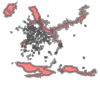

In [93]:
openspace_geom = geemap.ee_to_geopandas(openspace)['geometry'][0]
openspace_geom

In [94]:
utm_geom, epsg = latlon_to_utm(openspace_geom)
epsg

32613

In [95]:
exrings = [shapely.get_exterior_ring(poly) for poly in shapely.get_parts(utm_geom)]
exrings

[<LINEARRING (672716.574 2287773.14, 672707.427 2287765.96, 672702.318 228776...>,
 <LINEARRING (663798.881 2292368.738, 663805.696 2292357.689, 663825.904 2292...>,
 <LINEARRING (665035.894 2282695.526, 665196.1 2282958.133, 665173.359 228298...>,
 <LINEARRING (671200.283 2287023.27, 671202.396 2286950.386, 671275.25 228695...>,
 <LINEARRING (671354.404 2287120.301, 671198.412 2287117.403, 671199.782 2287...>,
 <LINEARRING (666078.129 2283183.722, 666178.137 2283103.918, 666238.084 2283...>,
 <LINEARRING (667476.087 2283504.232, 667548.563 2283494.254, 667570.946 2283...>,
 <LINEARRING (671955.891 2283189.348, 672014.408 2282818.219, 672122.038 2282...>,
 <LINEARRING (672927.434 2284110.737, 673072.408 2283880.26, 673266.805 22838...>,
 <LINEARRING (667782.214 2283687.625, 667755.087 2283464.658, 667776.406 2283...>,
 <LINEARRING (666548.746 2282978.492, 666465.984 2283018.021, 666405.69 22829...>,
 <LINEARRING (666715.353 2282819.246, 666666.804 2282716.969, 666684.414 2282...>,
 <LI

In [96]:
utm_segmentized = [ring.segmentize(max_segment_length=100) for ring in exrings]
utm_segmentized

[<LINEARRING (672716.574 2287773.14, 672707.427 2287765.96, 672702.318 228776...>,
 <LINEARRING (663798.881 2292368.738, 663805.696 2292357.689, 663825.904 2292...>,
 <LINEARRING (665035.894 2282695.526, 665075.945 2282761.178, 665115.997 2282...>,
 <LINEARRING (671200.283 2287023.27, 671202.396 2286950.386, 671275.25 228695...>,
 <LINEARRING (671354.404 2287120.301, 671276.408 2287118.852, 671198.412 2287...>,
 <LINEARRING (666078.129 2283183.722, 666128.133 2283143.82, 666178.137 22831...>,
 <LINEARRING (667476.087 2283504.232, 667548.563 2283494.254, 667556.024 2283...>,
 <LINEARRING (671955.891 2283189.348, 671970.52 2283096.566, 671985.149 22830...>,
 <LINEARRING (672927.434 2284110.737, 672975.759 2284033.911, 673024.084 2283...>,
 <LINEARRING (667782.214 2283687.625, 667773.172 2283613.303, 667764.129 2283...>,
 <LINEARRING (666548.746 2282978.492, 666465.984 2283018.021, 666435.837 2282...>,
 <LINEARRING (666715.353 2282819.246, 666691.078 2282768.107, 666666.804 2282...>,
 <LI

In [97]:
latlon_segmentized = [utm_to_latlon(ring, epsg) for ring in utm_segmentized]
latlon_segmentized

[<LINEARRING (-103.342 20.681, -103.342 20.681, -103.342 20.681, -103.342 20....>,
 <LINEARRING (-103.427 20.724, -103.427 20.724, -103.427 20.724, -103.426 20....>,
 <LINEARRING (-103.416 20.636, -103.416 20.637, -103.415 20.637, -103.415 20....>,
 <LINEARRING (-103.356 20.675, -103.356 20.674, -103.356 20.674, -103.356 20....>,
 <LINEARRING (-103.355 20.676, -103.356 20.676, -103.356 20.676, -103.356 20....>,
 <LINEARRING (-103.406 20.641, -103.405 20.64, -103.405 20.64, -103.405 20.64...>,
 <LINEARRING (-103.392 20.643, -103.392 20.643, -103.392 20.644, -103.392 20....>,
 <LINEARRING (-103.35 20.64, -103.349 20.639, -103.349 20.638, -103.349 20.63...>,
 <LINEARRING (-103.34 20.648, -103.34 20.648, -103.339 20.647, -103.339 20.64...>,
 <LINEARRING (-103.39 20.645, -103.39 20.644, -103.39 20.644, -103.39 20.643,...>,
 <LINEARRING (-103.401 20.639, -103.402 20.639, -103.403 20.639, -103.403 20....>,
 <LINEARRING (-103.4 20.637, -103.4 20.637, -103.4 20.636, -103.4 20.636, -10...>,
 <LI

In [98]:
latlon_points = [list(ring.coords) for ring in latlon_segmentized]

In [99]:
latlon_points

[[(-103.3417945, 20.681421000000004),
  (-103.341883, 20.681356999999995),
  (-103.3419326, 20.681305600000005),
  (-103.3419393, 20.681234699999997),
  (-103.3419245, 20.6810364),
  (-103.34189299996825, 20.680416900015498),
  (-103.3418615, 20.679797399999998),
  (-103.3418287, 20.679190200000004),
  (-103.3417571, 20.679193400000003),
  (-103.34115625016084, 20.679254401064313),
  (-103.34055540000001, 20.6793154),
  (-103.3398539, 20.679370799999997),
  (-103.3396179, 20.6797774),
  (-103.3393174, 20.6803344),
  (-103.339017, 20.680865199999996),
  (-103.3389728, 20.681004399999996),
  (-103.3390948, 20.6810822),
  (-103.3397433, 20.681084400000003),
  (-103.3404104, 20.6810797),
  (-103.3410488, 20.6812315),
  (-103.3415571, 20.681369600000004),
  (-103.3417945, 20.681421000000004)],
 [(-103.4269577, 20.723733199999995),
  (-103.4268933, 20.7236328),
  (-103.4267002, 20.7235425),
  (-103.4264535, 20.723572599999994),
  (-103.4263247, 20.723612699999993),
  (-103.4262389, 20.723723

In [100]:
allpoints = set([])
for ring in latlon_points:
    allpoints = allpoints.union(ring)

In [101]:
allpoints

{(-103.63163024980068, 20.92836540001706),
 (-103.38915443712428, 20.34315045245928),
 (-103.1438122, 20.734740100000003),
 (-102.9523076, 20.8486644),
 (-103.3899371, 20.808448400000003),
 (-103.41398370116133, 20.760683550349395),
 (-103.12933917509079, 20.766353750062397),
 (-103.32120900062083, 20.74195980065038),
 (-103.40177099781677, 20.669432101533417),
 (-102.94786599830536, 20.793891033440474),
 (-103.3244825, 20.752255899999998),
 (-103.4436581, 20.6690016),
 (-102.91341018206877, 20.34563486028811),
 (-103.3394287, 20.7060846),
 (-103.41829130053833, 20.801642700118734),
 (-103.1365699, 20.585101900000005),
 (-103.1932475, 20.62824459999999),
 (-102.98370665335254, 20.369812160931573),
 (-103.1932453, 20.4477815),
 (-102.9770389, 20.3444539),
 (-103.1677617, 20.659128700000004),
 (-103.38385894946182, 20.51386686678514),
 (-103.4446827, 20.604853599999995),
 (-103.2877891, 20.8080901),
 (-103.3358233, 20.742296200000002),
 (-103.15709029983402, 20.763189966693346),
 (-103.3

In [209]:
df = pd.DataFrame({'lat': [point[1] for point in allpoints], 'lon': [point[0] for point in allpoints]})

In [212]:
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.lon, df.lat), crs="EPSG:4326"
)

In [213]:
gdf

,lat,lon,geometry
0,20.928365,-103.631630,POINT (-103.63163 20.92837)
1,20.343150,-103.389154,POINT (-103.38915 20.34315)
2,20.734740,-103.143812,POINT (-103.14381 20.73474)
3,20.848664,-102.952308,POINT (-102.95231 20.84866)
4,20.808448,-103.389937,POINT (-103.38994 20.80845)
...,...,...,...
19529,20.735001,-103.218231,POINT (-103.21823 20.73500)
19530,20.741238,-103.309388,POINT (-103.30939 20.74124)
19531,20.628218,-103.286212,POINT (-103.28621 20.62822)
19532,20.764806,-103.406938,POINT (-103.40694 20.76481)


## The cells below are only for exporting to PBF, which is not necessary for this project.

In [ ]:
import xml.etree.ElementTree as ET
import osmium
import datetime

In [204]:
root = ET.Element("osm")
root.set('version', '0.6')
bounds = ET.Element("bounds")
bounds.set('minlat', str(bbox['S']))
bounds.set('maxlat', str(bbox['N']))
bounds.set('minlon', str(bbox['W']))
bounds.set('maxlon', str(bbox['E']))
root.append (bounds)
for counter, point in enumerate(allpoints):
    ele = ET.Element("node")
    ele.set('id', str(counter))
    ele.set('lat', str(point[1]))
    ele.set('lon', str(point[0]))
    ele.set('user', 'tedwong')
    ele.set('uid', '99999')
    ele.set('visible', 'true')
    ele.set('timestamp', datetime.datetime.now().strftime("%Y-%m-%dT%H:%M:%SZ"))
    ele.set('version', '1')
    ele.set('changeset', '999999')
    tag = ET.Element("tag")
    tag.set('k', 'dummy')
    tag.set('v', 'dummy')
    ele.append(tag)
    root.append(ele)

In [205]:
tree = ET.ElementTree(root)

In [206]:
tree.write('guadalajara_test.xml')

In [119]:
class NodeWriter(osmium.SimpleHandler):
    def __init__(self, writer):
        osmium.SimpleHandler.__init__(self)
        self.writer = writer
        self.num_nodes = 0

    def node(self, n):
        self.writer.add_node(n)
        self.num_nodes += 1

In [208]:
writer = osmium.SimpleWriter('guadalajara_test_999.pbf')
h = NodeWriter(writer)
h.apply_file('guadalajara_test.xml')
writer.close()